In [ ]:
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import plotting_functions as pf

h5_storage = 'RTK_simulation_output.h5'
store = pd.HDFStore(h5_storage)
ode_sim_df = store['ode_sim_out']


gb = ode_sim_df.groupby(["a", "b"])

r = [x for x in gb]
pf.plot_3d(r[0][1], "conc_RTK_0", "conc_GF_0", "a")
plt.show()



In [ ]:
import plotting_functions as pf
import seaborn as sns

def plot_3d(df, condition_x, condition_y, condition_z):
    g = sns.FacetGrid(df, col=condition_x, row=condition_y, hue='species', margin_titles=False)
    g = (g.map_dataframe(plt.plot, condition_z, 'n_species'))

    n = len(g.axes)
    epsilon = 0.15/(n+3)
    for i in reversed(range(n)):
        for j in reversed(range(n)):

            bottom = 1-i*1.0/n-2*epsilon

            left = j*1.0/n+2*epsilon

                
            g.axes[i][j].set_position([left, bottom, 1.0/n-epsilon, 1.0/n-epsilon]) # [left, bottom, width, height]
    
    # label only the top axis and side
    for i, axes_row in enumerate(g.axes):
        for j, axes_col in enumerate(axes_row):
           
            row, col = axes_col.get_title().split('|')
            if i == 0:
                axes_col.set_title(col.strip())
            else:
                axes_col.set_title('')

            if j == 0:
                ylabel = axes_col.get_ylabel()
                axes_col.set_ylabel(row.strip() + ' | ' + ylabel)
    plt.legend(bbox_to_anchor=(0,-.20), ncol=6)
    plt.savefig('time_array_test.pdf',  bbox_inches='tight')
    
    


l = plot_3d(r[0][1], "conc_RTK_0", "conc_GF_0", "time")



In [ ]:
print l.axes[0][0].get_position()
print l.axes[0][1].get_position()
print l.axes[5][5].get_position()
l.axes[0][0].set_position([0, .86, .8, .98])

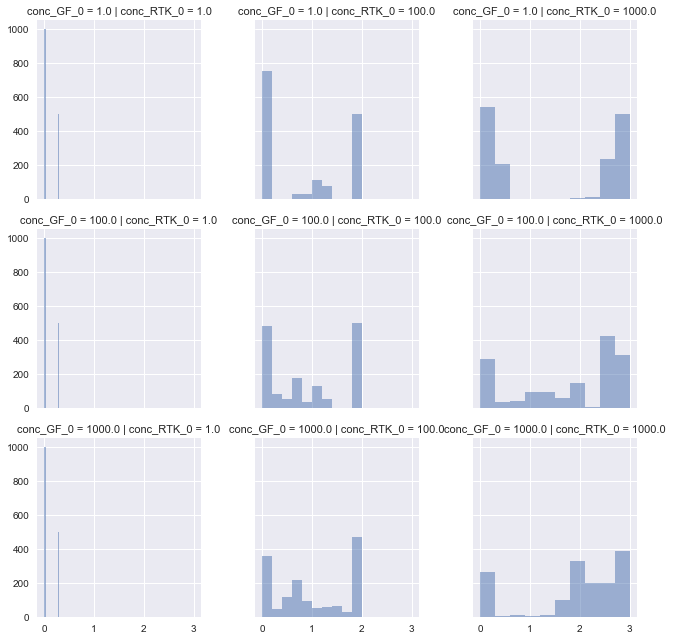

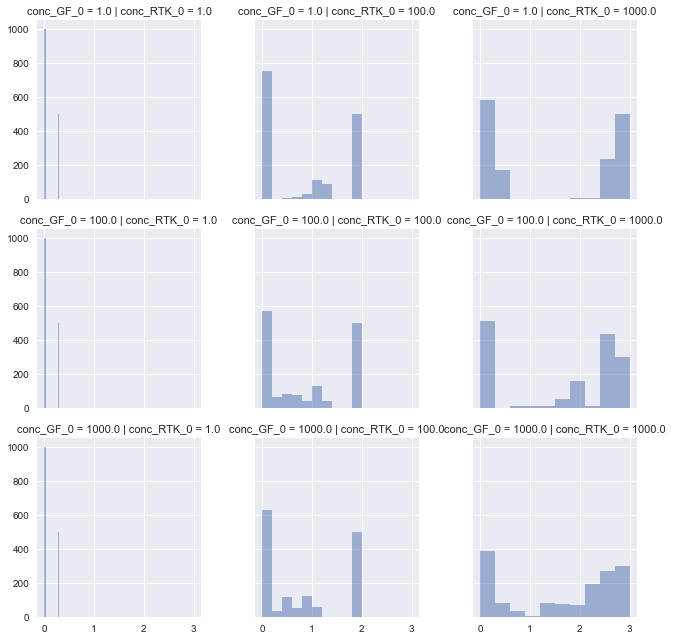

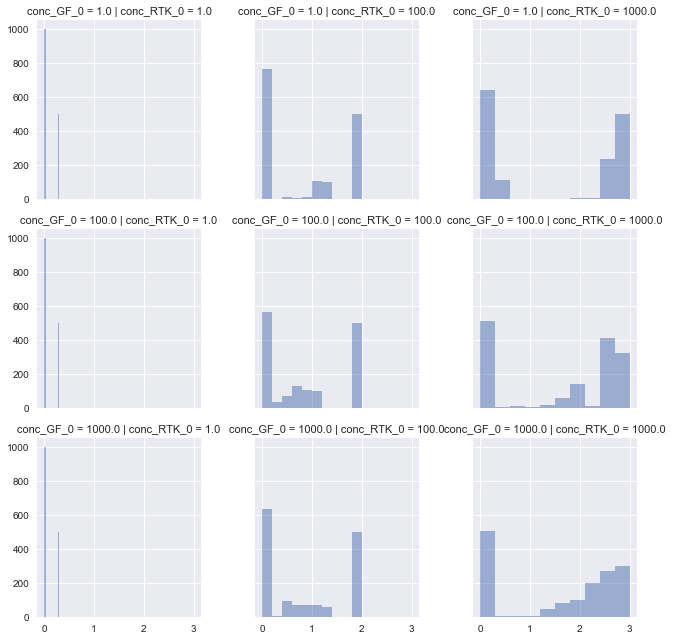

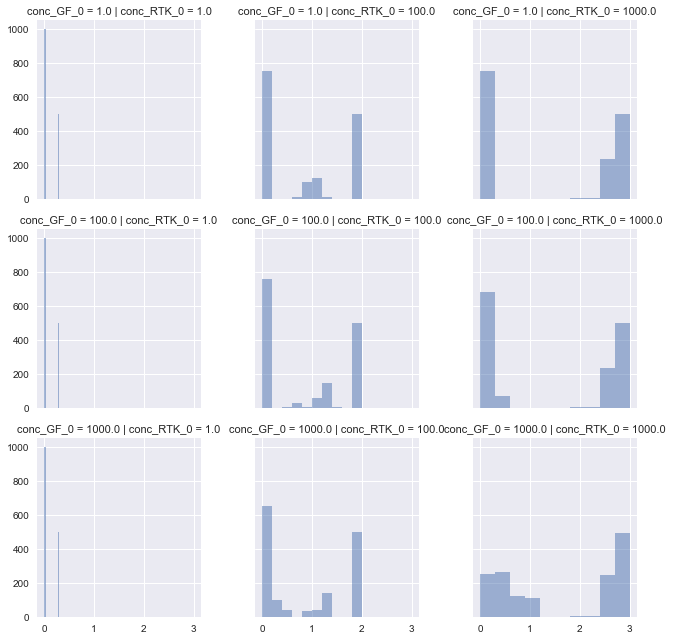

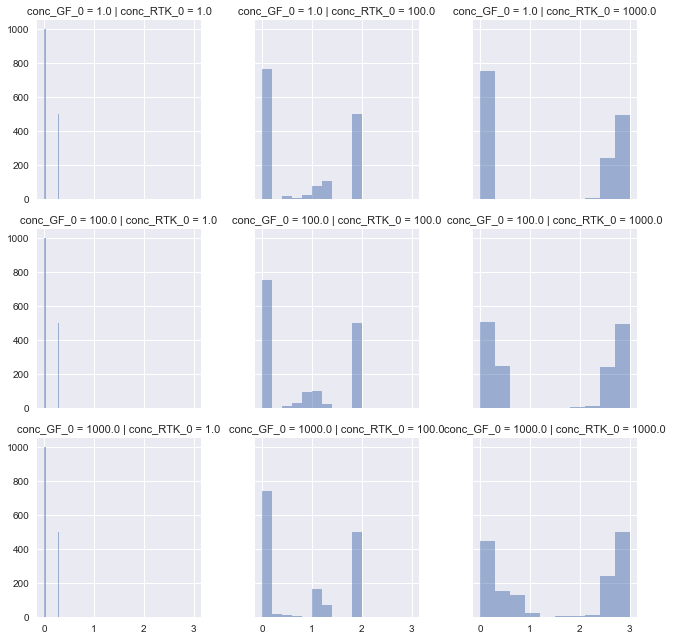

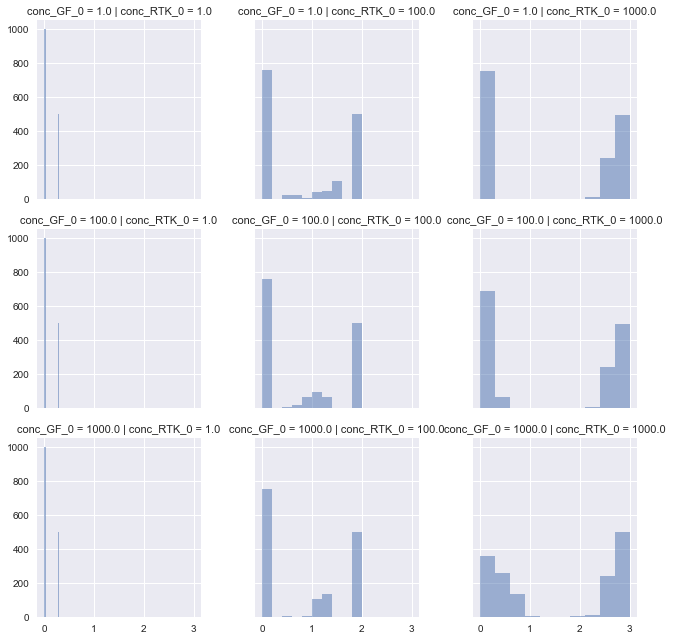

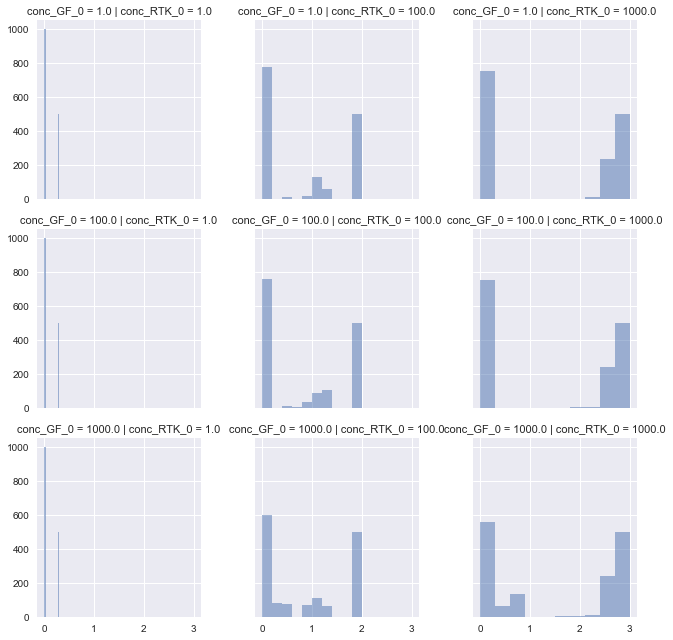

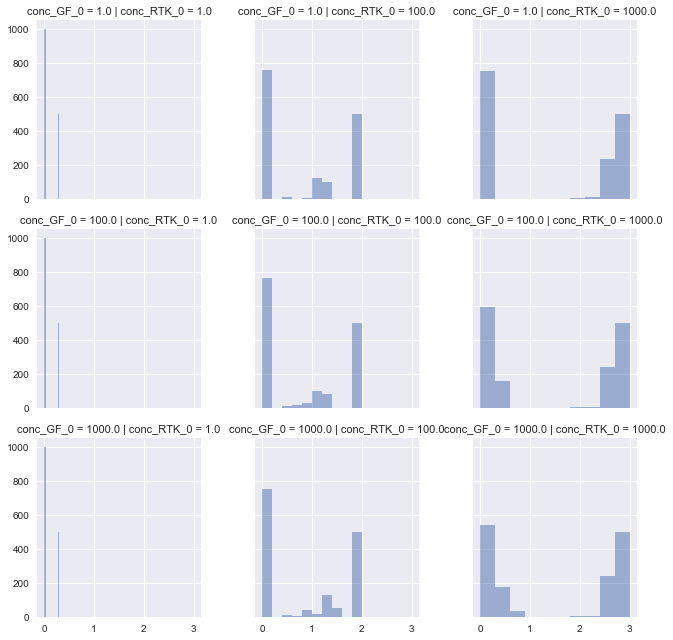

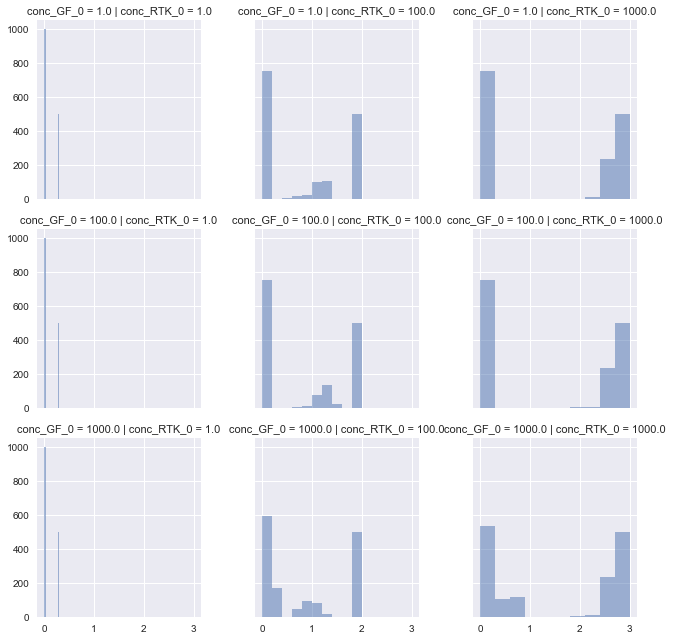

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
%matplotlib inline

df = pd.HDFStore('/Users/priyaveeraraghavan/Dropbox/RTK_model/RTK_simulation_output.h5')
simdf = df['/stoch_sim_out']

def plot_gaussian_bimodal(df, **kws):
    print df
    species_counts = df.values
    hist, bins, patches = plt.hist(species_counts, num_bins, alpha=0.5, **kws)
    
    gmm = GaussianMixture(n_components=2).fit(species_counts.reshape(-1, 1))
    for mean, var in zip(gmm.means_.tolist(), gmm.covars_.tolist()):
        y = mlab.normpdf(bins, mean, var)
        plt.plot(bins, y, 'r')
        
active = ['GF_RTK_RTK_GF_obs', 'RTK_RTK_obs']
exp_df_gen = simdf.groupby(['a', 'b'])

for idx, data in exp_df_gen:
    
    subset_idx = np.array(filter(lambda x: x != -1, 
                           [i if data['species'].values[i] in active 
                            else -1 for i in  range(data.shape[0])]))
   
    data2 = data.iloc[subset_idx].groupby(['conc_GF_0', 'conc_RTK_0', 'time'], as_index=False).sum()
    data2 = data2[['conc_GF_0', 'conc_RTK_0', 'n_species']] # grab only the active species RTK_RTK etc
    
    def facet(data, color, **kws):
 
        species_counts = data['n_species'].values
        hist, bins, patches = plt.hist(species_counts, alpha=0.5, **kws)
    
    g = sns.FacetGrid(data, row='conc_GF_0', col='conc_RTK_0')

    g = g.map_dataframe(facet)
    g.add_legend()


#for idx, data in exp_df_gen:
#    data = data.loc[filter(lambda x: x != -1, 
#                           [i if data['species'].values[i] not in active 
#                            else -1 for i in  range(data.shape[0])])] # grab only the active species RTK_RTK etc
#    d = np.histogram(data['n_species'])[0]
#    if len(filter(lambda x: x>0, d)) > 1:
#        plt.hist(data['n_species'], bins=25, alpha=0.5, label=str(idx))
#g = sns.FacetGrid(simdf, row='species')
#g = (g.map_dataframe(plt.hist, 'n_species', bins=100))

#plt.legend()
plt.show()

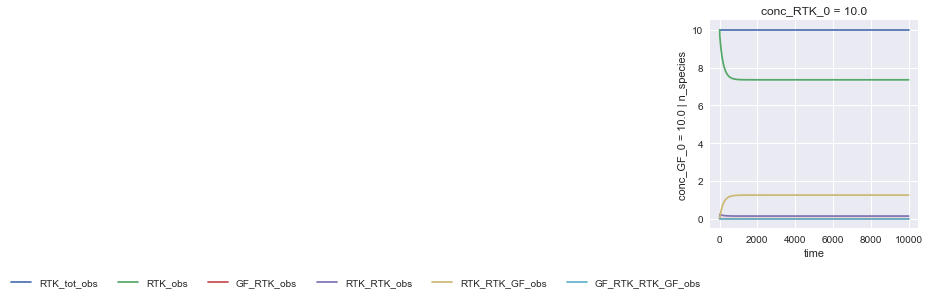

In [89]:
import simulating_functions as sf
import RTK_energy_model as rm
from pysb.simulator import ScipyOdeSimulator
import plotting_functions as pf

steady_state = False
model = rm.model
tspan = np.linspace(0, 100000, 1000)
variable_tuples = [('a', 0.01),
                  ('b', 1.0),
                  ('conc_RTK_0', 10.0),
                  ('conc_GF_0', 10.0)]
param_values = dict(variable_tuples)
df = sf.SimulationData(variable_tuples)
res = sf.simulate_condition(param_values, model, ScipyOdeSimulator, tspan, steady_state, df)
pf.plot_3d(res.data, "conc_RTK_0", "conc_GF_0", "time")


In [105]:
s = res.data.groupby('species')
epsilon = 0.00001
ss_time_all = 0
for idx, sdata in s:
    ss_value = sdata.tail(n=1)['n_species'].values[0]

    #ss_time = sdata[sdata['n_species'] > ss_value*(1-epsilon) and sdata['n_species'] < ss_value*(1+epsilon)].agg({'time': min})

    
    ss_times = sdata[sdata.apply(lambda x: x['n_species'] > ss_value*(1 - epsilon) and x['n_species'] < ss_value*(1+epsilon), axis=1)]
    ss_time_sim = ss_times.agg({'time': min})
    ss_time_all = max(ss_time_all, ss_time_sim.values[0])

print ss_time_all


    
    

time    2222.222222
dtype: float64
time    2272.272272
dtype: float64
time    2252.252252
dtype: float64
time    2142.142142
dtype: float64
time    2022.022022
dtype: float64
time    0.0
dtype: float64
2272.27227227
